### Import necessary libraries

In [2]:
!pip install emoji
!pip install contractions

In [3]:
import re
import contractions
import pandas as pd
import numpy as np
import re
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
# Negations to keep
negations = {"no", "not", "nor", "cannot", "can't", "don't", "won't", "doesn't", "isn't", "wouldn't",
             "aren't","hadn't","needn't","shouldn't","haven't", "weren't", "mustn't", "didn't", "couldn't", "hasn't", "wasn't", "shan't"}

# Remove negations from stop_words set
stop_words = stop_words.difference(negations)

lemmatizer = WordNetLemmatizer()


### Load and Explore Data

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/Colab_Notebooks/processed_tweets.csv'
# # Load data
# try:
#     df = pd.read_csv(file_path, encoding='utf-8')
#     print(f"Loaded data (UTF-8). Shape: {df.shape}")
# except UnicodeDecodeError:
#     df = pd.read_csv(file_path, encoding='ISO-8859-1')
#     print(f"Loaded data (ISO-8859-1). Shape: {df.shape}")
# except Exception as e:
#     print(f"Error loading data: {e}")
#     df = None


# df.head()

Loaded data (ISO-8859-1). Shape: (451332, 2)

DATA EXPLORATION
Shape: (451332, 2)
Columns: ['Tweet', 'Sentiment']
Missing values:
Tweet        1
Sentiment    0
dtype: int64

Sentiment distribution:
Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64


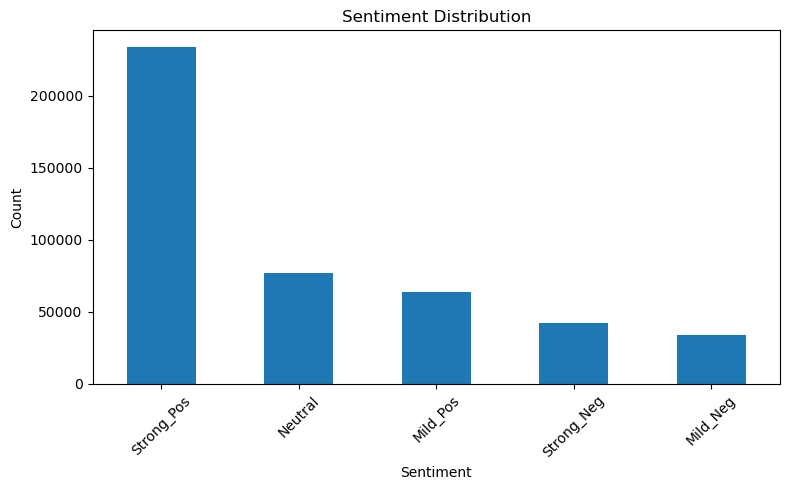

In [7]:
# Load data
try:
    df = pd.read_csv('Sentiment_Data.csv', encoding='utf-8')
    print(f"Loaded data (UTF-8). Shape: {df.shape}")
except UnicodeDecodeError:
    df = pd.read_csv('Sentiment_Data.csv', encoding='ISO-8859-1')
    print(f"Loaded data (ISO-8859-1). Shape: {df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    df = None

if df is not None:
    # Explore data
    print("\n" + "="*50 + "\nDATA EXPLORATION\n" + "="*50)
    print(f"Shape: {df.shape}\nColumns: {df.columns.tolist()}")
    print(f"Missing values:\n{df.isnull().sum()}")

    # Sentiment distribution
    sentiment_counts = df['Sentiment'].value_counts()
    print(f"\nSentiment distribution:\n{sentiment_counts}")
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
df.head(10)

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos
5,@JusticeStyle Happy Anniversary!!!....The Day ...,Mild_Pos
6,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,Mild_Pos
7,@parnel1123 @RealAndyLeeShow Happy Anniversary...,Mild_Pos
8,Freedom Convoy as InkBlot Test https://t.co/au...,Strong_Pos
9,@WSOnlineNews @DavidKrayden Happy Anniversary!...,Mild_Pos


In [9]:
# Define a mapping to combine labels
merge_map = {
    'Mild_Pos': 'positive',
    'Strong_Pos': 'positive',
    'Strong_Neg': 'negative',
    'Mild_Neg': 'negative'
}

# rray(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
#       dtype=object)

In [10]:
# Apply the mapping to the 'label' column
df['Sentiment'] = df['Sentiment'].replace(merge_map)

In [11]:

def preprocess(text):
    text = re.sub(r'#', ' ', text)                # Remove hash sign
    text = re.sub(r'[^a-z\s]', '', text)         # Remove special chars and retaining only alphabetic text.
    #tokens = word_tokenize(text)
    #tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]    #Remove Stopwords and apply lemmatization
    #return ' '.join(tokens)
    return text

In [12]:
print(df['Tweet'][0])
print(preprocess(df['Tweet'][0]))

@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's "American Pie") #FreeDumbConvoy #Freedumbers #FluTruxKlan #convoywatch #convoy #FreedomConvoy   https://t.co/ZT1cIPwmh9
angelicatoy appy nniversaryhe ay the ree ied n the tune of on ceans merican ie  reeumbonvoy  reedumbers  luruxlan  convoywatch  convoy  reedomonvoy   httpstcocwmh


In [13]:
#df['Tweet'] = df['Tweet'].apply(preprocess)

In [14]:
df.head(10)

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,positive
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,positive
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,positive
3,@NChartierET Happy Anniversary!!!....The Day t...,positive
4,@tabithapeters05 Happy Anniversary!!!....The D...,positive
5,@JusticeStyle Happy Anniversary!!!....The Day ...,positive
6,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,positive
7,@parnel1123 @RealAndyLeeShow Happy Anniversary...,positive
8,Freedom Convoy as InkBlot Test https://t.co/au...,positive
9,@WSOnlineNews @DavidKrayden Happy Anniversary!...,positive


In [15]:
df['Sentiment'].unique()

array(['positive', 'Neutral', 'negative'], dtype=object)

### Preprocess Text

In [17]:
def preprocess_text(text, slang_dict, abbreviation_dict, regex_patterns):
    """Preprocess text: regex, emojis, slang, abbreviations."""
    if pd.isna(text):
        return "", 0, 0, 0, 0

    text = str(text).lower()
    regex_count, slang_count, abbrev_count = 0, 0, 0

    # Handle emojis with emoji.demojize
    original_text = text
    text = emoji.demojize(text, delimiters=(' ', ' '))
    emoji_count = len(re.findall(r':\w+:', text))

    text = contractions.fix(text)                #Expand Contractions (e.g., "can't" → "cannot")
    text = re.sub(r'@\w+', ' ', text)             # Remove @mentions
    text = re.sub(r'#', ' ', text)                # Remove hash sign

    # Apply regex cleaning
    for pattern_name, pattern in regex_patterns.items():
        if pattern_name == 'multiple_spaces':
            text = re.sub(pattern, ' ', text)
        elif pattern_name == 'extra_whitespace':
            text = re.sub(pattern, '', text)
        elif pattern_name == 'repeated_chars':
            text = re.sub(pattern, r'\1\1', text)
        elif pattern_name == 'retweet':
            if re.search(pattern, text):
                text = re.sub(pattern, '', text)
                regex_count += 1
        else:
            if re.search(pattern, text):
                text = re.sub(pattern, ' ', text)
                regex_count += 1

    # Handle slang and abbreviations
    words = text.split()
    processed_words = []
    for word in words:
        word_clean = word.lower().rstrip('.,!?;:')
        if word_clean in slang_dict:
            processed_words.append(slang_dict[word_clean])
            slang_count += 1
        elif word_clean in abbreviation_dict:
            processed_words.append(abbreviation_dict[word_clean])
            abbrev_count += 1
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)

    # Remove punctuation (keep sentiment-relevant ones)
    text = re.sub(r'[^\w\s!?.]', '', text)
    # Step 1: Reduce repeated punctuation (!, ?, .) to single
    text = re.sub(r'([!?.]){2,}', r'\1', text)
    # Step 2: Add space after punctuation
    text = re.sub(r'([!?.])', r'\1 ', text)
    # Step 3: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text, regex_count, emoji_count, slang_count, abbrev_count

# Define dictionaries and patterns
slang_dict = {
    'lol': 'laugh out loud', 'omg': 'oh my god', 'wtf': 'what the fuck',
    'btw': 'by the way', 'tbh': 'to be honest', 'idk': 'i dont know'
}
abbreviation_dict = {
    'usa': 'united states of america', 'nyc': 'new york city',
    'govt': 'government', 'dr': 'doctor', 'hr': 'hour'
}
regex_patterns = {
    'url': r'http[s]?://\S+',
    'email': r'\b[\w\.-]+@[\w\.-]+\.\w+\b',
    'phone': r'\b\d{3}-\d{3}-\d{4}\b|\b\(\d{3}\)\s?\d{3}-\d{4}\b',
    'html_tags': r'<[^>]+>',
    'retweet': r'\bRT\b',
    'repeated_chars': r'(.)\1{2,}',
    'multiple_spaces': r'\s+',
    'newlines': r'\n|\r',
    'extra_whitespace': r'^\s+|\s+$'
}

# Apply preprocessing
if df is not None:
    print("\n" + "="*50 + "\nDATA PREPROCESSING\n" + "="*50)
    df['original_tweet'] = df['Tweet'].copy()
    results = df['Tweet'].apply(lambda x: preprocess_text(x, slang_dict, abbreviation_dict, regex_patterns))

    df['processed_tweet'] = [r[0] for r in results]
    total_regex = sum(r[1] for r in results)
    total_emojis = sum(r[2] for r in results)
    total_slang = sum(r[3] for r in results)
    total_abbrev = sum(r[4] for r in results)

    print(f"Preprocessing Statistics:")
    print(f"Regex applications: {total_regex}")
    print(f"Emojis handled: {total_emojis}")
    print(f"Slang terms handled: {total_slang}")
    print(f"Abbreviations handled: {total_abbrev}")

    df = df[df['processed_tweet'].str.strip() != ''].reset_index(drop=True)
    print(f"Shape after removing empty tweets: {df.shape}")


DATA PREPROCESSING
Preprocessing Statistics:
Regex applications: 223958
Emojis handled: 306
Slang terms handled: 3518
Abbreviations handled: 8787
Shape after removing empty tweets: (450926, 4)


In [18]:
print(df.head(10)['Tweet'][0])
print(df.head(10)['processed_tweet'][0])

@_angelica_toy Happy Anniversary!!!....The Day the FreeDUMB Died (In the tune of Don McLean's "American Pie") #FreeDumbConvoy #Freedumbers #FluTruxKlan #convoywatch #convoy #FreedomConvoy   https://t.co/ZT1cIPwmh9
happy anniversary. the day the freedumb died in the tune of don mcleans american pie freedumbconvoy freedumbers flutruxklan convoywatch convoy freedomconvoy


In [19]:
df.head(10)

,Tweet,Sentiment,original_tweet,processed_tweet
0,@_angelica_toy Happy Anniversary!!!....The Day...,positive,@_angelica_toy Happy Anniversary!!!....The Day...,happy anniversary. the day the freedumb died i...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,positive,@McfarlaneGlenda Happy Anniversary!!!....The D...,happy anniversary. the day the freedumb died i...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,positive,@thevivafrei @JustinTrudeau Happy Anniversary!...,happy anniversary. the day the freedumb died i...
3,@NChartierET Happy Anniversary!!!....The Day t...,positive,@NChartierET Happy Anniversary!!!....The Day t...,happy anniversary. the day the freedumb died i...
4,@tabithapeters05 Happy Anniversary!!!....The D...,positive,@tabithapeters05 Happy Anniversary!!!....The D...,happy anniversary. the day the freedumb died i...
5,@JusticeStyle Happy Anniversary!!!....The Day ...,positive,@JusticeStyle Happy Anniversary!!!....The Day ...,happy anniversary. the day the freedumb died i...
6,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,positive,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,happy anniversary. the day the freedumb died i...
7,@parnel1123 @RealAndyLeeShow Happy Anniversary...,positive,@parnel1123 @RealAndyLeeShow Happy Anniversary...,happy anniversary. the day the freedumb died i...
8,Freedom Convoy as InkBlot Test https://t.co/au...,positive,Freedom Convoy as InkBlot Test https://t.co/au...,freedom convoy as inkblot test
9,@WSOnlineNews @DavidKrayden Happy Anniversary!...,positive,@WSOnlineNews @DavidKrayden Happy Anniversary!...,happy anniversary. the day the freedumb died i...


In [20]:
df.to_csv('processed_tweets.csv', index=False)

# Load processed data from the saved CSV File

In [22]:
dataset = pd.read_csv('processed_tweets.csv')
dataset.head(10)

,Tweet,Sentiment,original_tweet,processed_tweet
0,@_angelica_toy Happy Anniversary!!!....The Day...,positive,@_angelica_toy Happy Anniversary!!!....The Day...,happy anniversary. the day the freedumb died i...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,positive,@McfarlaneGlenda Happy Anniversary!!!....The D...,happy anniversary. the day the freedumb died i...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,positive,@thevivafrei @JustinTrudeau Happy Anniversary!...,happy anniversary. the day the freedumb died i...
3,@NChartierET Happy Anniversary!!!....The Day t...,positive,@NChartierET Happy Anniversary!!!....The Day t...,happy anniversary. the day the freedumb died i...
4,@tabithapeters05 Happy Anniversary!!!....The D...,positive,@tabithapeters05 Happy Anniversary!!!....The D...,happy anniversary. the day the freedumb died i...
5,@JusticeStyle Happy Anniversary!!!....The Day ...,positive,@JusticeStyle Happy Anniversary!!!....The Day ...,happy anniversary. the day the freedumb died i...
6,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,positive,@Praiset22112963 @Emergencies_Act @ikwilson Ha...,happy anniversary. the day the freedumb died i...
7,@parnel1123 @RealAndyLeeShow Happy Anniversary...,positive,@parnel1123 @RealAndyLeeShow Happy Anniversary...,happy anniversary. the day the freedumb died i...
8,Freedom Convoy as InkBlot Test https://t.co/au...,positive,Freedom Convoy as InkBlot Test https://t.co/au...,freedom convoy as inkblot test
9,@WSOnlineNews @DavidKrayden Happy Anniversary!...,positive,@WSOnlineNews @DavidKrayden Happy Anniversary!...,happy anniversary. the day the freedumb died i...


In [23]:
dataset['Tweet'] = dataset['processed_tweet']
dataset.drop(columns=['processed_tweet'], inplace=True)
dataset.drop(columns=['original_tweet'], inplace=True)
dataset.head(10)

,Tweet,Sentiment
0,happy anniversary. the day the freedumb died i...,positive
1,happy anniversary. the day the freedumb died i...,positive
2,happy anniversary. the day the freedumb died i...,positive
3,happy anniversary. the day the freedumb died i...,positive
4,happy anniversary. the day the freedumb died i...,positive
5,happy anniversary. the day the freedumb died i...,positive
6,happy anniversary. the day the freedumb died i...,positive
7,happy anniversary. the day the freedumb died i...,positive
8,freedom convoy as inkblot test,positive
9,happy anniversary. the day the freedumb died i...,positive


In [24]:
dataset.duplicated().sum()

66695

In [25]:
dataset.shape

(450926, 2)

In [26]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [27]:
dataset.shape

(384231, 2)

In [28]:
# Check total number of nulls per column
print(dataset.isnull().sum())

Tweet        0
Sentiment    0
dtype: int64


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384231 entries, 0 to 384230
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      384231 non-null  object
 1   Sentiment  384231 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB


In [30]:
dataset.describe()

,Tweet,Sentiment
count,384231,384231
unique,384122,3
top,freedom convoy organizer tamara lich denied bail,positive
freq,2,248483


# Tokenization, Lemmatization, and removing Stop_words

In [32]:
import string

# Download required NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/mukulgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mukulgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mukulgarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mukulgarg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mukulgarg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
# Initialize tools
punctuations = set(string.punctuation)

def clean_tokens(text):
    text = str(text).lower()
    tokens = word_tokenize(text)

    # Remove punctuation & stopwords, lemmatize
    clean_words = []
    for word in tokens:
        if word not in stop_words and word not in punctuations:
            lemma = lemmatizer.lemmatize(word)
            clean_words.append(lemma)

    return ' '.join(clean_words)


In [34]:
# Apply to dataset
dataset['cleaned_tweet'] = dataset['Tweet'].apply(clean_tokens)
dataset.head(10)

,Tweet,Sentiment,cleaned_tweet
0,happy anniversary. the day the freedumb died i...,positive,happy anniversary day freedumb died tune mclea...
1,freedom convoy as inkblot test,positive,freedom convoy inkblot test
2,well itâs pretty easy to see what their agenda...,positive,well itâs pretty easy see agenda pierre remain...
3,you belong in jail. vaccinemandates crimesagai...,Neutral,belong jail vaccinemandates crimesagainsthuman...
4,freedumbconvoy freedomconvoy freedumbers freed...,Neutral,freedumbconvoy freedomconvoy freedumbers freed...
5,your head is so far up trudeauâs ass you can s...,positive,head far trudeauâs as see lunch trudeau doesnâ...
6,the freedom convoy you supported which include...,positive,freedom convoy supported included diagolon acc...
7,freedomconvoy,Neutral,freedomconvoy
8,the freedomconvoy 1 year anniversary. they do ...,negative,freedomconvoy 1 year anniversary not like free...
9,those knee drops remind me of something. oh ri...,negative,knee drop remind something oh right trudeaus c...


### Extract Features and Analyze **Separability**

In [36]:
dataset.head(10)

,Tweet,Sentiment,cleaned_tweet
0,happy anniversary. the day the freedumb died i...,positive,happy anniversary day freedumb died tune mclea...
1,freedom convoy as inkblot test,positive,freedom convoy inkblot test
2,well itâs pretty easy to see what their agenda...,positive,well itâs pretty easy see agenda pierre remain...
3,you belong in jail. vaccinemandates crimesagai...,Neutral,belong jail vaccinemandates crimesagainsthuman...
4,freedumbconvoy freedomconvoy freedumbers freed...,Neutral,freedumbconvoy freedomconvoy freedumbers freed...
5,your head is so far up trudeauâs ass you can s...,positive,head far trudeauâs as see lunch trudeau doesnâ...
6,the freedom convoy you supported which include...,positive,freedom convoy supported included diagolon acc...
7,freedomconvoy,Neutral,freedomconvoy
8,the freedomconvoy 1 year anniversary. they do ...,negative,freedomconvoy 1 year anniversary not like free...
9,those knee drops remind me of something. oh ri...,negative,knee drop remind something oh right trudeaus c...



FEATURE EXTRACTION & SEPARABILITY
Top separability features:
tweet_length: 1.0242
word_count: 1.0241


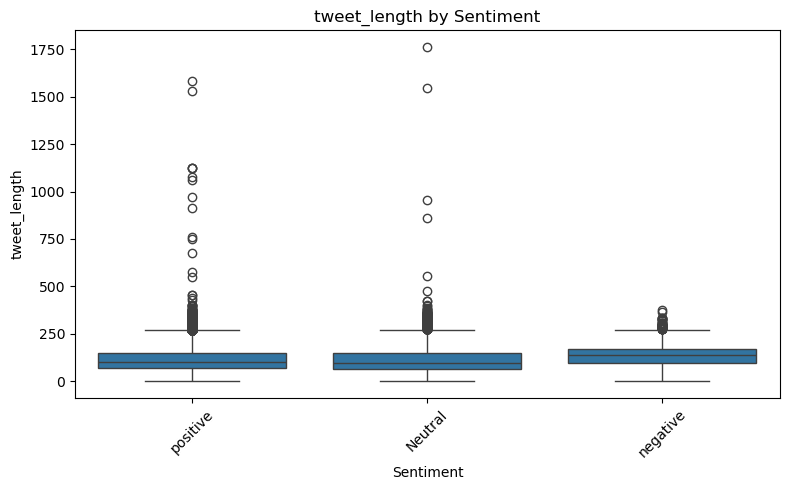

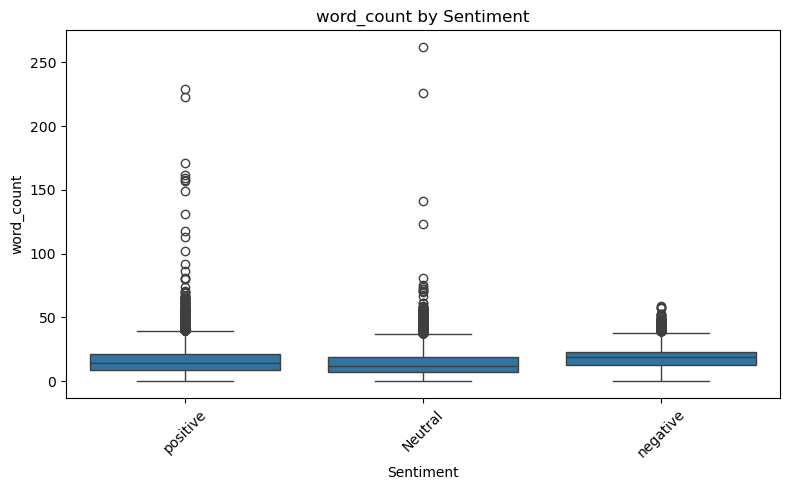

In [37]:
if dataset is not None:
    print("\n" + "="*50 + "\nFEATURE EXTRACTION & SEPARABILITY\n" + "="*50)

    # Extract features
    dataset['tweet_length'] = dataset['cleaned_tweet'].str.len()
    dataset['word_count'] = dataset['cleaned_tweet'].str.split().str.len()
    #dataset['avg_word_length'] = dataset['tweet_length'] / dataset['word_count'].replace(0, 1)
    # dataset['exclamation_count'] = dataset['cleaned_tweet'].str.count('!')
    # dataset['uppercase_ratio'] = dataset['cleaned_tweet'].str.count(r'[A-Z]') / dataset['tweet_length'].replace(0, 1)
    # dataset['hashtag_count'] = dataset['cleaned_tweet'].str.count('#')

    #positive_words = ['good', 'great', 'awesome']
    #negative_words = ['bad', 'terrible', 'awful']
    #dataset['positive_word_count'] = dataset['cleaned_tweet'].str.lower().str.count('|'.join(positive_words))
    #dataset['negative_word_count'] = dataset['cleaned_tweet'].str.lower().str.count('|'.join(negative_words))
    #dataset['sentiment_score'] = dataset['positive_word_count'] - dataset['negative_word_count']

    # Class separability
    feature_columns = ['tweet_length', 'word_count']#, 'avg_word_length',          #'exclamation_count','uppercase_ratio', 'hashtag_count',
                       #'positive_word_count',
                      #negative_word_count', 'sentiment_score']

    separability_scores = {}
    for feature in feature_columns:
        overall_var = dataset[feature].var()
        class_vars = dataset.groupby('Sentiment')[feature].var().mean()
        separability_scores[feature] = overall_var / (class_vars + 1e-10)

    sorted_features = sorted(separability_scores.items(), key=lambda x: x[1], reverse=True)
    best_features = [f[0] for f in sorted_features[:3]]

    print("Top separability features:")
    for feature, score in sorted_features[:3]:
        print(f"{feature}: {score:.4f}")

    # Visualize top features
    for feature in best_features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Sentiment', y=feature, data=dataset)
        plt.title(f'{feature} by Sentiment')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [38]:
dataset.head(10)

,Tweet,Sentiment,cleaned_tweet,tweet_length,word_count
0,happy anniversary. the day the freedumb died i...,positive,happy anniversary day freedumb died tune mclea...,133,15
1,freedom convoy as inkblot test,positive,freedom convoy inkblot test,27,4
2,well itâs pretty easy to see what their agenda...,positive,well itâs pretty easy see agenda pierre remain...,99,16
3,you belong in jail. vaccinemandates crimesagai...,Neutral,belong jail vaccinemandates crimesagainsthuman...,83,6
4,freedumbconvoy freedomconvoy freedumbers freed...,Neutral,freedumbconvoy freedomconvoy freedumbers freed...,57,5
5,your head is so far up trudeauâs ass you can s...,positive,head far trudeauâs as see lunch trudeau doesnâ...,136,19
6,the freedom convoy you supported which include...,positive,freedom convoy supported included diagolon acc...,123,17
7,freedomconvoy,Neutral,freedomconvoy,13,1
8,the freedomconvoy 1 year anniversary. they do ...,negative,freedomconvoy 1 year anniversary not like free...,57,8
9,those knee drops remind me of something. oh ri...,negative,knee drop remind something oh right trudeaus c...,84,11


In [39]:
print(dataset.columns)

Index(['Tweet', 'Sentiment', 'cleaned_tweet', 'tweet_length', 'word_count'], dtype='object')


In [40]:
for d in dataset.columns:
  print(d, ": ", dataset[d].nunique())

Tweet :  384122
Sentiment :  3
cleaned_tweet :  380386
tweet_length :  408
word_count :  93


In [41]:
# dataset.to_csv('/content/drive/My Drive/Colab_Notebooks/processed_tweets.csv', index=False)

In [42]:
# file_path = '/content/drive/My Drive/Colab_Notebooks/processed_tweets.csv'
# # Load data
# try:
#     dataset = pd.read_csv(file_path, encoding='utf-8')
#     print(f"Loaded data (UTF-8). Shape: {dataset.shape}")
# except UnicodeDecodeError:
#     dataset = pd.read_csv(file_path, encoding='ISO-8859-1')
#     print(f"Loaded data (ISO-8859-1). Shape: {dataset.shape}")
# except Exception as e:
#     print(f"Error loading data: {e}")
#     dataset = None


# dataset.head()

# SVM using GloVe

In [44]:
dataset.head(10)

,Tweet,Sentiment,cleaned_tweet,tweet_length,word_count
0,happy anniversary. the day the freedumb died i...,positive,happy anniversary day freedumb died tune mclea...,133,15
1,freedom convoy as inkblot test,positive,freedom convoy inkblot test,27,4
2,well itâs pretty easy to see what their agenda...,positive,well itâs pretty easy see agenda pierre remain...,99,16
3,you belong in jail. vaccinemandates crimesagai...,Neutral,belong jail vaccinemandates crimesagainsthuman...,83,6
4,freedumbconvoy freedomconvoy freedumbers freed...,Neutral,freedumbconvoy freedomconvoy freedumbers freed...,57,5
5,your head is so far up trudeauâs ass you can s...,positive,head far trudeauâs as see lunch trudeau doesnâ...,136,19
6,the freedom convoy you supported which include...,positive,freedom convoy supported included diagolon acc...,123,17
7,freedomconvoy,Neutral,freedomconvoy,13,1
8,the freedomconvoy 1 year anniversary. they do ...,negative,freedomconvoy 1 year anniversary not like free...,57,8
9,those knee drops remind me of something. oh ri...,negative,knee drop remind something oh right trudeaus c...,84,11


## Writing Code For Model

In [46]:
#Importing libraries for model building
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [47]:
# !curl -L -O http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [48]:
# Load GloVe vectors
def load_glove_embeddings(filepath):
    embeddings = {}
    print("Loading GloVe embeddings...")
    start_time = time.time()
    with open(filepath, encoding='utf8') as f:
        for i, line in enumerate(f):
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
            if i % 100000 == 0 and i > 0:
                print(f"  Loaded {i} lines...")
    duration = time.time() - start_time
    print(f"Completed loading {len(embeddings)} word vectors in {duration:.2f} seconds.\n")
    return embeddings

glove_path = 'glove.6B.50d.txt'  # Update this path
glove_embeddings = load_glove_embeddings(glove_path)
embedding_dim = 50


Loading GloVe embeddings...
  Loaded 100000 lines...
  Loaded 200000 lines...
  Loaded 300000 lines...
Completed loading 400000 word vectors in 1.56 seconds.



In [49]:
dataset['cleaned_tweet'][0]

'happy anniversary day freedumb died tune mcleans american pie freedumbconvoy freedumbers flutruxklan convoywatch convoy freedomconvoy'

In [50]:
import time

# Modify vectorize_text to handle non-string values
def vectorize_text(text, glove, dim=50):
    if not isinstance(text, str):  # Check if the text is a string
        return np.zeros(dim)  # Return zero vector for non-string values

    words = text.split()
    valid_vectors = [glove[word] for word in words if word in glove]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(dim)

print("Vectorizing tweets...")
start = time.time()

X = np.vstack(dataset['cleaned_tweet'].apply(lambda x: vectorize_text(str(x), glove_embeddings, embedding_dim)))
print(f"Vectorization done in {time.time()-start:.2f} seconds\n")


Vectorizing tweets...
Vectorization done in 2.67 seconds



In [51]:
# 3. Encode labels with timing
print("Encoding labels...")
start_time = time.time()
le = LabelEncoder()
y = le.fit_transform(dataset['Sentiment'])
duration = time.time() - start_time
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for label, code in label_mapping.items():
    print(f"\033[1m{label}\033[0m --> \033[1m{code}\033[0m")
print(f"Encoded labels in {duration:.4f} seconds.\n")

Encoding labels...
Neutral --> 0
negative --> 1
positive --> 2
Encoded labels in 0.0199 seconds.



In [52]:
dataset.columns

Index(['Tweet', 'Sentiment', 'cleaned_tweet', 'tweet_length', 'word_count'], dtype='object')

['tweet_length', 'word_count',
       'avg_word_length', 'positive_word_count', 'negative_word_count',
       'sentiment_score']

In [54]:
# Stack original embeddings + new features
additional_features = dataset[['tweet_length', 'word_count']]#, 'avg_word_length', 'positive_word_count', 'negative_word_count', 'sentiment_score']].values
X = np.hstack((X, additional_features))

print(f"Features shape after adding numerical features: {X.shape}\n")

Features shape after adding numerical features: (384231, 52)



In [55]:
X.shape

(384231, 52)

In [56]:
# 4. Train-test split with timing
print("Splitting data into train and test sets...")
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
duration = time.time() - start_time
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Split done in {duration:.4f} seconds.\n")

Splitting data into train and test sets...
Training samples: 307384
Testing samples: 76847
Split done in 0.0417 seconds.



In [57]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Undersample the training data using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


In [58]:
X_train_resampled.shape

(157686, 52)

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [73]:
# 5. Train SVM with timing
print("Training SVM classifier...")
start_time = time.time()

clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train_resampled, y_train_resampled)

# clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced'))
# clf.fit(X_train_resampled, y_train_resampled)

print(clf)

duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds.\n")

Training SVM classifier...
SVC(class_weight='balanced')
Training completed in 706.39 seconds.



In [74]:
# 6. Predict and evaluate with timing
print("Evaluating model...")
start_time = time.time()
y_pred = clf.predict(X_test)
duration = time.time() - start_time
acc = accuracy_score(y_test, y_pred)
print(f"Prediction done in {duration:.4f} seconds.")
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Evaluating model...
Prediction done in 515.6199 seconds.
Accuracy: 0.5362

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.51      0.41      0.45     13198
    negative       0.28      0.71      0.41     13981
    positive       0.83      0.52      0.64     49668

    accuracy                           0.54     76847
   macro avg       0.54      0.55      0.50     76847
weighted avg       0.67      0.54      0.56     76847



In [75]:
from sklearn.metrics import accuracy_score

# Predict on training and test sets
y_train_pred = clf.predict(X_train_resampled)

# Calculate accuracies
train_acc = accuracy_score(y_train_resampled, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")


Training Accuracy: 0.5406
Test Accuracy:     0.5362


In [76]:
import pickle

# Save the model, label encoder, and data in a single pickle file
save_data = {
    'svm_model': clf,
    # 'svm_model_1vsRest': classifier,
    'label_encoder': le,
    'X_test': X_test,
    'y_test': y_test,
    'X_train': X_train,
    'y_train': y_train,
    'y_pred': y_pred,
    'y_train_pred': y_train_pred,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

with open('rbf_svm_model_and_data_with_undersampling.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("Model and data saved successfully in a single file.")

Model and data saved successfully in a single file.


In [77]:
import pickle
with open('rbf_svm_model_and_data_with_undersampling.pkl', 'rb') as f:
    saved_data = pickle.load(f)

# Access the saved data
clf = saved_data['svm_model']
le = saved_data['label_encoder']
X_test = saved_data['X_test']
y_test = saved_data['y_test']
X_train = saved_data['X_train']
y_train = saved_data['y_train']
y_pred = saved_data['y_pred']
y_train_pred = saved_data['y_train_pred']
X_train_resampled = saved_data['X_train_resampled']
y_train_resampled = saved_data['y_train_resampled']
# classifier_1VsR = saved_data['svm_model_1vsRest']

Training Data Evaluation

Accuracy: 0.5406
Precision (macro): 0.5701642293219412
Recall (macro): 0.5406313813528151
F1 Score (macro): 0.5363413046389803
Precision (weighted): 0.5701642293219412
Recall (weighted): 0.5406313813528151
F1 Score (weighted): 0.5363413046389803

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.68      0.41      0.51     52562
    negative       0.47      0.70      0.57     52562
    positive       0.56      0.51      0.53     52562

    accuracy                           0.54    157686
   macro avg       0.57      0.54      0.54    157686
weighted avg       0.57      0.54      0.54    157686



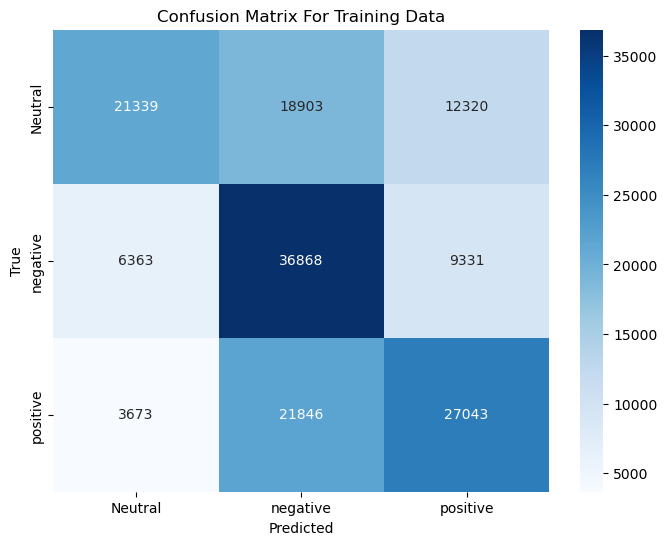

In [78]:

print("Training Data Evaluation")
print("="*50)
print("")

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# 1. Accuracy
acc = accuracy_score(y_train_resampled, y_train_pred)
print(f"Accuracy: {acc:.4f}")

# 2. Precision, Recall, F1 Score (macro, micro, weighted)
print("Precision (macro):", precision_score(y_train_resampled, y_train_pred, average='macro'))
print("Recall (macro):", recall_score(y_train_resampled, y_train_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_train_resampled, y_train_pred, average='macro'))

print("Precision (weighted):", precision_score(y_train_resampled, y_train_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_train_resampled, y_train_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_train_resampled, y_train_pred, average='weighted'))

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_train_resampled, y_train_pred, target_names=le.classes_))

# 4. Confusion Matrix
cm = confusion_matrix(y_train_resampled, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For Training Data')
plt.show()


Testing Data Evaluation

Accuracy: 0.5362
Precision (macro): 0.5395417957666746
Recall (macro): 0.5463669170969975
F1 Score (macro): 0.4995085755392685
Precision (weighted): 0.6724407479309655
Recall (weighted): 0.5361692714094239
F1 Score (weighted): 0.5647466710151309

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.51      0.41      0.45     13198
    negative       0.28      0.71      0.41     13981
    positive       0.83      0.52      0.64     49668

    accuracy                           0.54     76847
   macro avg       0.54      0.55      0.50     76847
weighted avg       0.67      0.54      0.56     76847



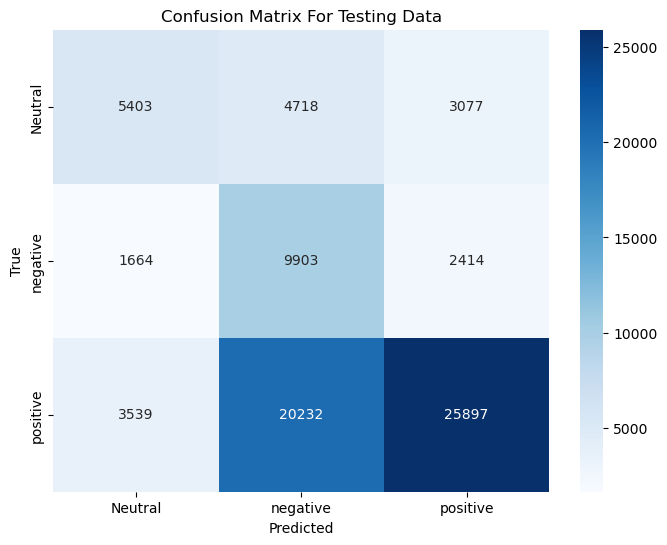

In [79]:

print("Testing Data Evaluation")
print("="*50)
print("")

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# y_test: true labels
# y_pred: predicted labels from model

# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# 2. Precision, Recall, F1 Score (macro, micro, weighted)
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For Testing Data')
plt.show()


In [81]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Train classifier
classifier = OneVsRestClassifier(SVC(kernel='rbf'))
classifier.fit(X_train_resampled, y_train_resampled)

In [ ]:


# Prepare label binarization
classes = np.unique(y_train_resampled)
n_classes = len(classes)

# Binarize labels
y_train_bin = label_binarize(y_train_resampled, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)



# Decision scores
y_train_score = classifier.decision_function(X_train_resampled)
y_test_score = classifier.decision_function(X_test)

# ROC & AUC
fpr_train, tpr_train, roc_auc_train = {}, {}, {}
fpr_test, tpr_test, roc_auc_test = {}, {}, {}

for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Macro AUC scores
roc_auc_train_macro = roc_auc_score(y_train_bin, y_train_score, average='macro')
roc_auc_test_macro = roc_auc_score(y_test_bin, y_test_score, average='macro')

print(f"Macro-average Train AUC: {roc_auc_train_macro:.4f}")
print(f"Macro-average Test AUC:  {roc_auc_test_macro:.4f}")

# Plotting
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr_train[i], tpr_train[i],
             linestyle='--',
             color=colors[i % len(colors)],
             label=f'Train Class {i} AUC = {roc_auc_train[i]:.2f}')
    
    plt.plot(fpr_test[i], tpr_test[i],
             linestyle='-',
             color=colors[i % len(colors)],
             label=f'Test Class {i} AUC = {roc_auc_test[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Train vs Test)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
